In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [74]:
# zt=np.array([0,1,2,3,4.0,15,16,17,18,19,30,31,32,33,34])
# dz2=zt*0.0+1.0
# pi=zt*0.0+1.0
# print(zt.shape)

# np.average([0,1,2,3,4])

# zk=np.array([17.0])
# pik=[]
# for i in zk:
#     pik.append(zt*0.0+1.0)
# pik=np.array(pik)

# zv_idx=0

# pi*pik[zv_idx]*(zt-zk[zv_idx])**2/dz2**2 

# pi*pik[zv_idx] /dz2

# np.sum( pi*pik[zv_idx]*(zt-zk[zv_idx])**2/dz2**2   )

# 1156.000000 + 1089.000000

# for zv_idx in range(len(zk)):
#     num  =2*np.sum( pi*pik[zv_idx]*(zt-zk[zv_idx])**2/dz2**2   )
#     deno =np.sum( pi*pik[zv_idx] /dz2)
#     print("T[",zv_idx,"] = ",num,"/",deno, " = ",num/deno)
    

### Free Energy plots from log

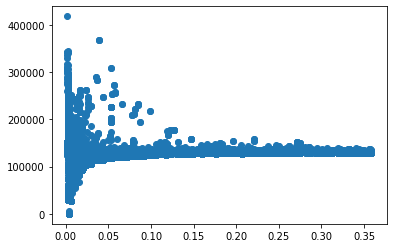

In [76]:
f= open("DAonGPU/log",'r')
l=f.readline()
beta=[]
freeEn=[]
while l:
    if(l[0]=='$'):
#         print(l)
        item=l[:-1].split(',')
#         print(item[1],item[2])
        beta.append(float(item[2]))
        freeEn.append(float(item[3]))
    l=f.readline()
minm=min(freeEn)
freeEn=np.array(freeEn)-minm +1.0
f.close()

freeEn.shape

plt.scatter(beta,freeEn)
# plt.xscale('log')
# plt.yscale('log')

## Vertex plots from reading log

In [77]:
def get_vertexMatches(vertexs_truth,vertexs_set):
    M=len(vertexs_truth)
    N=len(vertexs_set)
    matched_vertex=[-1 for i in range(M)]
    matched_vertexR2=[-1 for i in range(M)]
    matched_vertexR2X=[-1 for i in range(M)]
    
    set_matched_vertex=np.zeros(N)-1
 
    deltaR2s=np.zeros(N*M)
    deltaR2sX=np.zeros(N*M)
    for idx in range(M):
        z=vertexs_truth[idx]
        for j in range(N):
            deltaR2s[idx*N+j]=abs(vertexs_set[j]-z)
            deltaR2sX[idx*N+j]=abs(vertexs_set[j]-z)

    sorted_idx=np.argsort(deltaR2s)
    trk_found=0
    for idx in sorted_idx:
    #    if(deltaR2s[idx]>deltaRCUT):
    #        break;
        x=int(idx/N)
        if matched_vertex[x]!=-1:
            continue
        y= idx % N
        if set_matched_vertex[y]!=-1:
            continue
        set_matched_vertex[y]=x
        if y<0 :    #sanity check
            print("\n\n oh ho !! problem !! \n\n")
        matched_vertex[x]=y
        matched_vertexR2[x]=deltaR2s[idx]
        matched_vertexR2X[x]=deltaR2sX[idx]
        trk_found+=1
        if trk_found==M:
            break
    return matched_vertex,matched_vertexR2,matched_vertexR2X

### Reading the log

In [90]:
f= open("DAonGPU/log",'r')
l=f.readline()
count=0
zVtx=[]
zVtx_count=[]
while l:
    if(l[0]=='@'):
        count+=1
        zVtx.append([])
        zVtx_count.append(0)
        l=f.readline()
        continue
    if(l[0]=='*'):
#         print(l)
        item=l[:-1].split(',')
#         print(item[1],item[2])
        zVtx[-1].append(float(item[1]))
        zVtx_count[-1]+=1
    l=f.readline()

print("nevents = ",len(zVtx))
f.close()
nevents=len(zVtx)

nevents =  200


In [102]:
for i in range(nevents):
    for z in zVtx[i]:
        if z>1000:
            print(i)
            break

0
3
7
11
15
16
18
27
28
29
31
37
46
48
55
56
70
74
75
79
84
89
90
96
97
98
100
103
105
108
111
118
119
123
126
127
131
133
134
135
138
142
143
152
154
155
161
162
163
166
169
171
173
182
184
189
190
191
194
196


### Reading the Reco from CMSSW

In [91]:
f=open('DAonGPU/tracks.csv','r')
COUNT_MAX=nevents
l=f.readline()
evt_idx=[]
count=0
zt=[]
zt_count=[]
while l:
    if l[0]=='#':
        l=f.readline()
        continue

    if l[0]=='@':
        count+=1
        if count > COUNT_MAX:
            break
        zt.append([])
#         if zt_count!=[]:
#             print(zt_count[-1])
        zt_count.append(0)
        l=f.readline()
        continue
    item=l[:-1].split(',')
    zt[-1].append(float(item[1]))
    zt_count[-1]+=1
    l=f.readline()
print("reco tracks read for ",len(zt)," events")
f.close()

f=open('DAonGPU/vertices.csv','r')
l=f.readline()
evt_idx=[]
count=0
zv=[]
zv_err=[]
zv_count=[]
while l:
    if l[0]=='#':
        l=f.readline()
        continue

    if l[0]=='@':
        count+=1
        if count > COUNT_MAX:
            break
        zv.append([])
        zv_err.append([])
#         if zv_count!=[]:
#             print(zv_count[-1])
        zv_count.append(0)
        l=f.readline()
        continue

    item=l[:-1].split(',')
    zv[-1].append(float(item[1]))
    zv_err[-1].append(float(item[2]))
    zv_count[-1]+=1
    l=f.readline()
print("reco vertices read for ",len(zv)," events")
f.close()
    

reco tracks read for  200  events
reco vertices read for  200  events


#### No track Bug supression for event ids with 0 tracks

In [92]:
idx_p=[]
for i in range(nevents):
    if zt_count[i]==0:
        idx_p.append(i)
for idx in idx_p:
    print("deleting idx  = ",idx)
    zv[idx] = [0]
    zv_err[idx] = [0]
    zv_count[idx] = [0]
    zVtx[idx] = [0]
    zVtx_count[idx] = [0]


In [93]:
deltaZ=[]
dN=[]
zVertexReco=[]
zVertexDAonGPU=[]
for i in range(nevents):
    if(i>2000):
        break
    nv_DAonGPU=len(zVtx[i])
    nv_reco   =len(zv[i])
    dN.append(nv_DAonGPU-nv_reco)
    zVtx[i]=np.array(zVtx[i])
    zv[i]=np.array(zv[i])
    dmat=[]
    # matched_vertex,matched_vertexR2,matched_vertexR2X
    m,dm,dzm=get_vertexMatches(zv[i],zVtx[i])
    for j in dm:
        deltaZ.append(j)
    for j in zVtx[i]:
        zVertexDAonGPU.append(j)
    for j in zv[i]:
        zVertexReco.append(j)
zVertexReco=np.ndarray.flatten(np.array(zVertexReco))
zVertexDAonGPU=np.ndarray.flatten(np.array(zVertexDAonGPU))

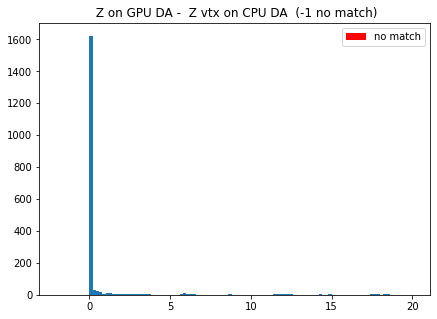

In [94]:
plt.figure(figsize=(7,5))
plt.hist(deltaZ,bins=100,range=(0,20.0))
plt.hist(deltaZ,bins=100,range=(-2,0),color='r',label='no match')
plt.title(" Z on GPU DA -  Z vtx on CPU DA  (-1 no match)")
plt.legend()
# plt.savefig("deltaZ.png")

In [95]:
for i in range(20):
    if abs(dN[i])>6:
        print(i,dN[i])

0 8
1 9
2 9
3 28
4 11
6 11
9 21
11 125
12 26
13 16
14 10
15 16
16 27
17 7
18 30


(array([1.]), array([-1.5, -0.5]), <BarContainer object of 1 artists>)
(array([3.]), array([-0.5,  0.5]), <BarContainer object of 1 artists>)
125 -1


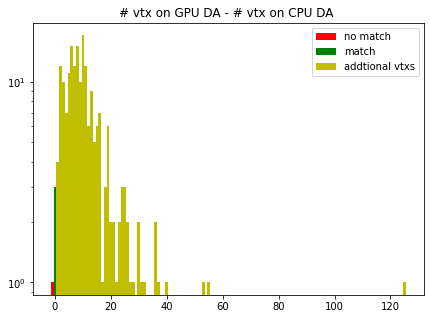

In [96]:
plt.figure(figsize=(7,5))
# x=plt.hist(dN,bins=7,range=(-3.5,3.5))
# x=plt.hist(dN,bins=70)
# x=plt.hist(dN)
minX=min(dN)
maxX=max(dN)
if(minX<0):
    x=plt.hist(dN,bins=abs(minX),range=(minX-0.5,-0.5),color='r',label='no match')
print(x)    
x=plt.hist(dN,bins=1,range=(-0.5,0.5),color='g',label='match')
print(x)
if maxX>0:
    plt.hist(dN,bins=abs(maxX),range=(0.5,maxX+0.5),color='y',label='addtional vtxs')
plt.title("# vtx on GPU DA - # vtx on CPU DA ")
# plt.savefig("deltaN.png")
plt.legend()
print(max(dN),min(dN))
plt.yscale('log')

Text(0.5, 1.0, 'vertex z distribution')

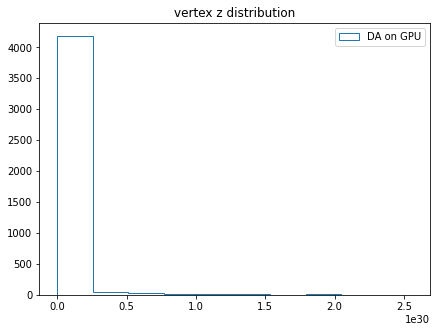

In [100]:
plt.figure(figsize=(7,5))
# plt.hist(zVertexReco,histtype='step',label='DA on CPU')
plt.hist(zVertexDAonGPU,histtype='step',label='DA on GPU')
plt.legend()
plt.title('vertex z distribution')
# plt.yscale('log')
# plt.savefig("zDistribution.png")

tolal number of tracks =  349
tolal number of GPU Verttices =  32
tolal number of Reco Verttices =  10


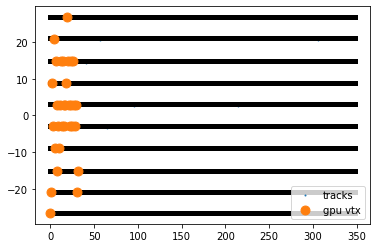

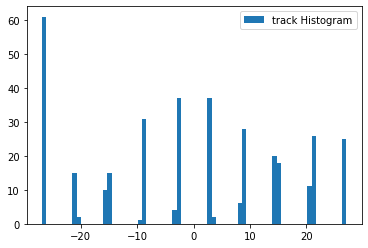

In [73]:
idx=1

x=np.arange(zt_count[idx])
y=np.array(zt[idx])
xmax=len(x)
print("tolal number of tracks = ",zt_count[idx])
plt.scatter(x,y,s=1,label='tracks')


xv=np.arange(zVtx_count[idx])
yv=np.array(zVtx[idx])
xmax=max(xmax,len(x))
print("tolal number of GPU Verttices = ",zVtx_count[idx])
plt.scatter(xv,yv,s=80,zorder=10,label='gpu vtx')

xv=np.arange(xmax)
print("tolal number of Reco Verttices = ",zv_count[idx])
for vtx in zv[idx]:
    yv=xv*0+vtx
    plt.plot(xv,yv,color='black',linewidth=5)
plt.legend(loc=4)
plt.figure()
hh=plt.hist(y,bins=70,label='track Histogram')
plt.legend()